# NYC EMS Incidents 2013-2017

https://data.cityofnewyork.us/Public-Safety/EMS-Incident-Dispatch-Data/76xm-jjuj

Use Case: Predict number of EMS calls incidents in order to be adequately prepared to handle all of them. 

In [304]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime
import itertools
import warnings
import sklearn

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Grouper
from matplotlib.pylab import rcParams
from sklearn.model_selection import TimeSeriesSplit
# from fbprophet import Prophet

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# DO NOT RUN the following cells, we used them to clean a big nasty CSV and create a new cleaner one which is imported later

In [ ]:
raw_data = pd.read_csv('../Downloads/EMS_Incident_Dispatch_Data.csv',  error_bad_lines=False, sep=';')

In [ ]:
dropped_data = raw_data.drop(['FIRST_TO_HOSP_DATETIME', 'FIRST_HOSP_ARRIVAL_DATETIME', 'ATOM', 'CAD_INCIDENT_ID', 
                  'FIRST_ASSIGNMENT_DATETIME', 'FIRST_ACTIVATION_DATETIME', 'FIRST_ON_SCENE_DATETIME',
                 'INCIDENT_CLOSE_DATETIME', 'INCIDENT_DISPATCH_AREA', 'CITYCOUNCILDISTRICT', 'COMMUNITYDISTRICT',
                 'COMMUNITYSCHOOLDISTRICT', 'CONGRESSIONALDISTRICT', 'REOPEN_INDICATOR', 'SPECIAL_EVENT_INDICATOR',
                 'TRANSFER_INDICATOR', 'INCIDENT_TRAVEL_TM_SECONDS_QY'], axis=1)

###### Incident Breakdown by Borough 

In [ ]:
dropped_data['BOROUGH'].value_counts()

In [ ]:
plt.figure(figsize=(18,4))
plt.bar(dropped_data['BOROUGH'].value_counts().index, dropped_data['BOROUGH'].value_counts())

###### Incident Breakdown by Initial Severity Level

In [ ]:
dropped_data['INITIAL_SEVERITY_LEVEL_CODE'].value_counts()

In [ ]:
plt.figure(figsize=(18,4))
plt.bar(dropped_data['INITIAL_SEVERITY_LEVEL_CODE'].value_counts().index, dropped_data['INITIAL_SEVERITY_LEVEL_CODE'].value_counts())

###### Incident Breakdown by Final Severity Level

In [ ]:
dropped_data['FINAL_SEVERITY_LEVEL_CODE'].value_counts()

In [ ]:
plt.figure(figsize=(18,4))
plt.bar(dropped_data['FINAL_SEVERITY_LEVEL_CODE'].value_counts().index, dropped_data['FINAL_SEVERITY_LEVEL_CODE'].value_counts())

###### Incident Breakdown by Change in Severity Level 

Breakdown shows that for a majority of incidents, the severity level remained the same between initial and final. 

In [ ]:
delta_data = dropped_data

In [ ]:
delta_data['Change_In_Severity'] = dropped_data['INITIAL_SEVERITY_LEVEL_CODE'] - dropped_data['FINAL_SEVERITY_LEVEL_CODE']

In [ ]:
delta_data['Change_In_Severity'].value_counts()

###### Convert INCIDENT_DATETIME column from string to datetime and set column as index

In [ ]:
# delta_data['proper_time'] = pd.to_datetime(delta_data['INCIDENT_DATETIME'])

In [ ]:
delta_data.set_index('INCIDENT_DATETIME', inplace = True)

In [ ]:
ts = pd.DataFrame(data.index.value_counts()).sort_index()

In [ ]:
ts.sort_values('INCIDENT_DATETIME', ascending=False)

###### Grouping Data by Year

In [ ]:
ts.index = pd.to_datetime(ts.index)

In [ ]:
annual_freq = ts.groupby(Grouper(freq='A'))

In [ ]:
new_df = pd.DataFrame()
for yr, group in annual_freq:
    new_df[yr.year] = group.values.ravel()

In [ ]:
new_df.plot(figsize = (22,15), subplots=True, legend=True)
plt.show()

In [ ]:
new_df.plot(figsize = (18,10), subplots=False, legend=True)
plt.show()

In [ ]:
new_df.hist(figsize = (12,6))
plt.show()

In [ ]:
new_df.boxplot(figsize = (15,8))
plt.show()

In [ ]:
year_matrix = new_df.T
plt.matshow( year_matrix, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r)
plt.show()

###### Uh-oh we have a leap year

In [ ]:
ts.head()

In [ ]:
ts.loc['2016-02-29']

In [ ]:
leap_ts = ts[ts.index != '2016-02-29']

In [ ]:
annual_freq = leap_ts.groupby(Grouper(freq='A'))

In [ ]:
leap_df = pd.DataFrame()
for yr, group in annual_freq:
    leap_df[yr.year] = group.values.ravel()

In [ ]:
leap_df

#### yayyyy the leap year stuff has been figured out

In [ ]:
leap_df.plot(figsize = (22,15), subplots=True, legend=True)
plt.show()

In [ ]:
data.columns

# START HERE WITH SEMI CLEANED CSV

In [115]:
coerced_data = pd.read_csv('../ems_datetime_fixed.csv')

In [116]:
coerced_data = coerced_data.drop(['Unnamed: 0', 'INCIDENT_DATETIME'], axis=1).set_index('proper_time')

In [117]:
coerced_data.head()

,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,ZIPCODE,POLICEPRECINCT,STANDBY_INDICATOR,Change_In_Severity
proper_time,,,,,,,,,,,,,,,
2013-01-01 00:00:04,RESPIR,4,RESPIR,4,Y,101,Y,797.0,N,82.0,BRONX,10472.0,43.0,N,0
2013-01-01 00:00:19,CARD,3,CARD,3,Y,59,Y,851.0,N,93.0,BRONX,10454.0,40.0,N,0
2013-01-01 00:01:04,ARREST,1,ARREST,1,Y,29,Y,429.0,N,83.0,QUEENS,11418.0,102.0,N,0
2013-01-01 00:01:16,SICK,6,SICK,6,Y,56,Y,828.0,N,82.0,BRONX,10453.0,46.0,N,0
2013-01-01 00:01:26,INJURY,5,INJURY,5,Y,32,Y,856.0,N,82.0,BRONX,10457.0,48.0,N,0


One of our goals is to measure the frequency of calls over different time periods, so we need a way to tally calls when we call the "resample" method. Here we'll add a column where we assign a simple value of 1 to every call, and soon we'll use it to tally.

In [118]:
coerced_data['count'] = 1

In [119]:
coerced_data.head()

,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,ZIPCODE,POLICEPRECINCT,STANDBY_INDICATOR,Change_In_Severity,count
proper_time,,,,,,,,,,,,,,,,
2013-01-01 00:00:04,RESPIR,4,RESPIR,4,Y,101,Y,797.0,N,82.0,BRONX,10472.0,43.0,N,0,1
2013-01-01 00:00:19,CARD,3,CARD,3,Y,59,Y,851.0,N,93.0,BRONX,10454.0,40.0,N,0,1
2013-01-01 00:01:04,ARREST,1,ARREST,1,Y,29,Y,429.0,N,83.0,QUEENS,11418.0,102.0,N,0,1
2013-01-01 00:01:16,SICK,6,SICK,6,Y,56,Y,828.0,N,82.0,BRONX,10453.0,46.0,N,0,1
2013-01-01 00:01:26,INJURY,5,INJURY,5,Y,32,Y,856.0,N,82.0,BRONX,10457.0,48.0,N,0,1


In [120]:
coerced_data.index = pd.to_datetime(coerced_data.index)

In [121]:
weather_data = pd.read_csv('weather_data.csv')

In [122]:
weather_data.head()

,Date,Max Temp,Min Temp,Avg Temp,Precipitation Water Equiv,Snowfall,Snow/Ice Depth
0,2013-01-01,40,26.0,33.0,0.0,0.0,0.0
1,2013-01-02,33,22.0,27.5,0.0,0.0,0.0
2,2013-01-03,32,24.0,28.0,0.0,0.0,0.0
3,2013-01-04,37,30.0,33.5,0.0,0.0,0.0
4,2013-01-05,42,32.0,37.0,0.0,0.0,0.0


In [123]:
weather_data.set_index('Date', inplace=True)

In [124]:
weather_data.index = pd.to_datetime(weather_data.index)

In [125]:
weather_data.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=1826, freq=None)

In [157]:
weekly_average_temperature_data = pd.DataFrame(weather_data['Avg Temp'].resample('W').mean())

In [159]:
weekly_sum_precipitation = pd.DataFrame(weather_data['Precipitation Water Equiv'].resample('W').sum())

In [160]:
weekly_sum_snowfall = pd.DataFrame(weather_data['Snowfall'].resample('W').sum())

In [128]:
holiday_data = pd.read_csv('holiday_data.csv')

In [129]:
holiday_data.head()

,Date,Holiday
0,2013-01-01,True
1,2013-01-02,False
2,2013-01-03,False
3,2013-01-04,False
4,2013-01-05,False


In [130]:
holiday_data.set_index('Date', inplace=True)

In [131]:
holiday_data.index = pd.to_datetime(holiday_data.index)

In [132]:
holiday_data.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=1826, freq=None)

In [133]:
weekly_sum_holidays = holiday_data.resample('W').sum()

In [134]:
weekly_sum_holidays.head()

,Holiday
Date,
2013-01-06,1.0
2013-01-13,0.0
2013-01-20,0.0
2013-01-27,1.0
2013-02-03,0.0


### Now we have a time series to play with!

In [135]:
len(coerced_data['count'].resample('W').sum()) - 26

235

In [136]:
weekly_call_volume = coerced_data['count'].resample('W').sum()

In [137]:
daily_call_volume = coerced_data['count'].resample('D').sum()

In [138]:
weekly_average_response_time = coerced_data['INCIDENT_RESPONSE_SECONDS_QY'].resample('W').mean()

In [139]:
weekly_average_response_time = weekly_average_response_time / 60

In [140]:
daily_average_response_time = coerced_data['INCIDENT_RESPONSE_SECONDS_QY'].resample('D').mean()

In [141]:
daily_average_response_time = daily_average_response_time / 60

In [162]:
weekly_average_response_time_df = pd.DataFrame(data=weekly_average_response_time, index=weekly_average_response_time.index)

In [163]:
weekly_average_response_time_df = pd.merge(weekly_average_response_time_df, weekly_average_temperature_data, left_index=True, right_index=True)
weekly_average_response_time_df = pd.merge(weekly_average_response_time_df, weekly_sum_precipitation, left_index=True, right_index=True)
weekly_average_response_time_df = pd.merge(weekly_average_response_time_df, weekly_sum_snowfall, left_index=True, right_index=True)
weekly_average_response_time_df = pd.merge(weekly_average_response_time_df, weekly_sum_holidays, left_index=True, right_index=True)

In [167]:
weekly_average_response_time_df.columns = ['avg_response_time_min', 'avg_temp', 'total_precip', 'total_snowfall', 'total_holidays']

In [168]:
weekly_average_response_time_df.head()

,avg_response_time_min,avg_temp,total_precip,total_snowfall,total_holidays
proper_time,,,,,
2013-01-06,11.203026,33.166667,0.0001,0.001,1.0
2013-01-13,11.848662,43.214286,0.5700,0.000,0.0
2013-01-20,9.846154,38.428571,0.9000,0.001,0.0
2013-01-27,8.906825,21.071429,0.0701,1.501,1.0
2013-02-03,9.237061,35.428571,1.2600,0.401,0.0


In [335]:
weekly_call_volume_df = pd.DataFrame(data=weekly_call_volume, index=weekly_call_volume.index)

In [336]:
weekly_call_volume_df = pd.merge(weekly_call_volume_df, weekly_average_temperature_data, left_index=True, right_index=True)
weekly_call_volume_df = pd.merge(weekly_call_volume_df, weekly_sum_precipitation, left_index=True, right_index=True)
weekly_call_volume_df = pd.merge(weekly_call_volume_df, weekly_sum_snowfall, left_index=True, right_index=True)
weekly_call_volume_df = pd.merge(weekly_call_volume_df, weekly_sum_holidays, left_index=True, right_index=True)

In [339]:
weekly_call_volume_df.columns = ['sum of weekly calls', 'avg_temp', 'total_precip', 'total_snowfall', 'total_holidays']

In [340]:
weekly_call_volume_df.head()

,sum of weekly calls,avg_temp,total_precip,total_snowfall,total_holidays
proper_time,,,,,
2013-01-06,23449,33.166667,0.0001,0.001,1.0
2013-01-13,27193,43.214286,0.5700,0.000,0.0
2013-01-20,25044,38.428571,0.9000,0.001,0.0
2013-01-27,23313,21.071429,0.0701,1.501,1.0
2013-02-03,24656,35.428571,1.2600,0.401,0.0


## Let's see what this all looks like

In [177]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(ser):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ser.values)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return None

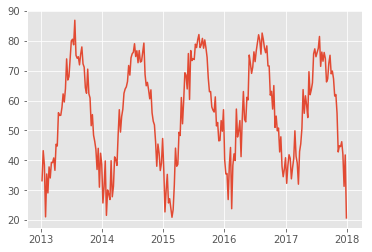

Results of Dickey-Fuller Test:
Test Statistic                -7.373287e+00
p-value                        8.855958e-11
#Lags Used                     1.600000e+01
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


In [178]:
plt.plot(weekly_average_response_time_df['avg_temp'])
plt.show()
dickey_fuller(weekly_average_response_time_df['avg_temp'])

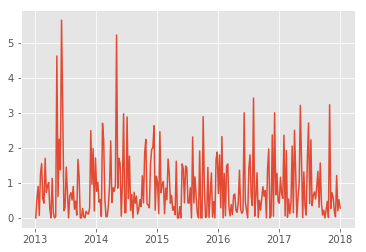

Results of Dickey-Fuller Test:
Test Statistic                -1.654803e+01
p-value                        1.956570e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.600000e+02
Critical Value (1%)           -3.455754e+00
Critical Value (5%)           -2.872721e+00
Critical Value (10%)          -2.572728e+00
dtype: float64


In [173]:
plt.plot(weekly_average_response_time_df['total_precip'])
plt.show()
dickey_fuller(weekly_average_response_time_df['total_precip'])

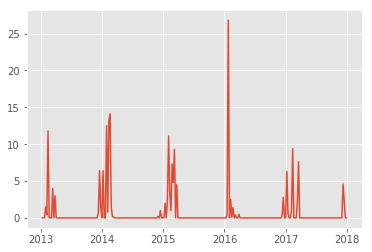

Results of Dickey-Fuller Test:
Test Statistic                -6.801037e+00
p-value                        2.236803e-09
#Lags Used                     2.000000e+00
Number of Observations Used    2.580000e+02
Critical Value (1%)           -3.455953e+00
Critical Value (5%)           -2.872809e+00
Critical Value (10%)          -2.572775e+00
dtype: float64


In [174]:
plt.plot(weekly_average_response_time_df['total_snowfall'])
plt.show()
dickey_fuller(weekly_average_response_time_df['total_snowfall'])

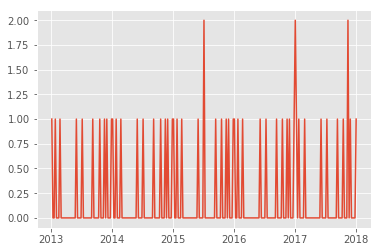

Results of Dickey-Fuller Test:
Test Statistic                  -4.678656
p-value                          0.000092
#Lags Used                      13.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


In [176]:
plt.plot(weekly_average_response_time_df['total_holidays'])
plt.show()
dickey_fuller(weekly_average_response_time_df['total_holidays'])

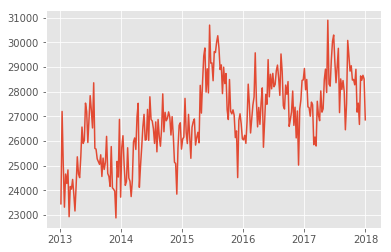

In [16]:
plt.plot(weekly_call_volume)
plt.show()

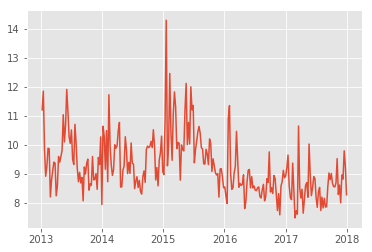

In [17]:
plt.plot(weekly_average_response_time)

In [172]:
dickey_fuller(weekly_call_volume), print('\n'), dickey_fuller(weekly_average_response_time)

Results of Dickey-Fuller Test:
Test Statistic                  -2.774700
p-value                          0.061980
#Lags Used                       3.000000
Number of Observations Used    257.000000
Critical Value (1%)             -3.456054
Critical Value (5%)             -2.872853
Critical Value (10%)            -2.572799
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                  -3.759599
p-value                          0.003349
#Lags Used                       3.000000
Number of Observations Used    257.000000
Critical Value (1%)             -3.456054
Critical Value (5%)             -2.872853
Critical Value (10%)            -2.572799
dtype: float64


(None, None, None)

In [20]:
dickey_fuller(daily_average_response_time), dickey_fuller(daily_call_volume)

Results of Dickey-Fuller Test:
Test Statistic                   -4.825441
p-value                           0.000049
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   -2.971561
p-value                           0.037637
#Lags Used                       25.000000
Number of Observations Used    1800.000000
Critical Value (1%)              -3.433988
Critical Value (5%)              -2.863147
Critical Value (10%)             -2.567626
dtype: float64


(None, None)

At first glance, we get a decent P-val for our stationarity check, but we know we can do better. There must be seasonality to our data.

In [21]:
# for year in [2013, 2014, 2015, 2016, 2017]:
#     print('\n' + str(year) + '\n')
#     print(dickey_fuller(weekly_average_response_time['{}-01-01'.format(str(year)):'{}-12-31'.format(str(year))]))

In [22]:
def rolling_statistics(timeseries):
    rolmean = timeseries.rolling(window = 8, center = False).mean()
    rolstd = timeseries.rolling(window = 8, center = False).std()
    fig = plt.figure(figsize=(12,7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

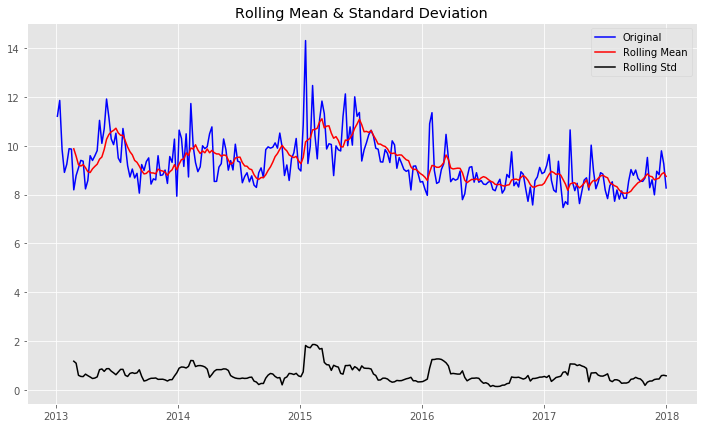

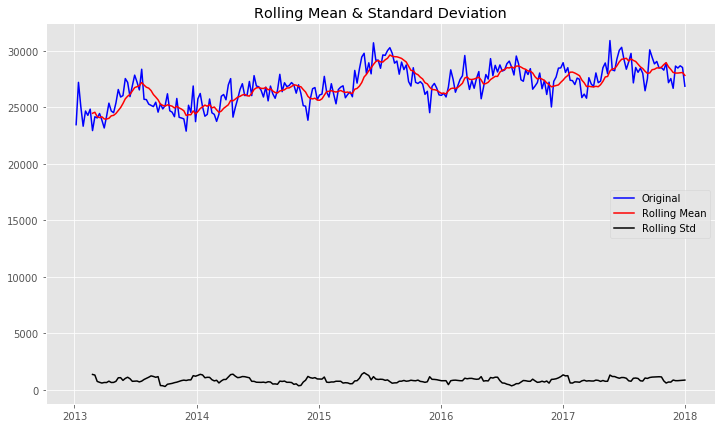

In [23]:
rolling_statistics(weekly_average_response_time)
rolling_statistics(weekly_call_volume)

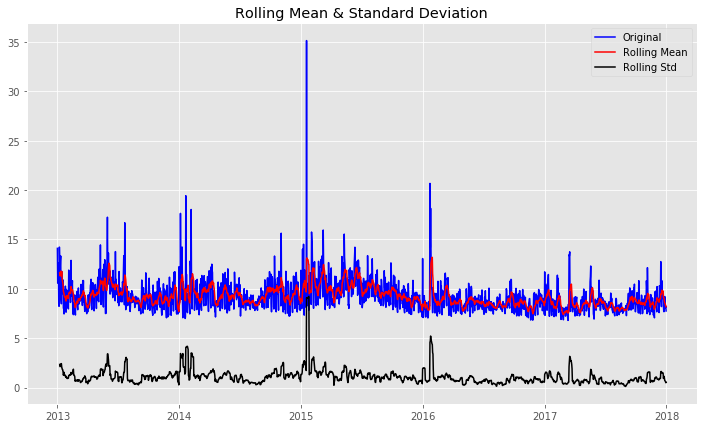

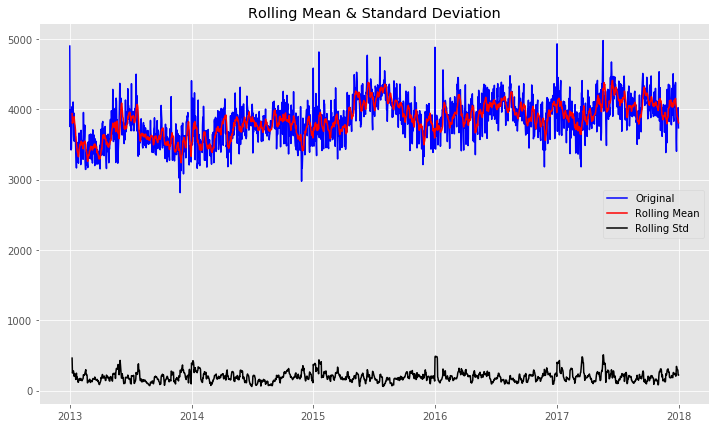

In [24]:
rolling_statistics(daily_average_response_time)
rolling_statistics(daily_call_volume)

<Figure size 432x288 with 0 Axes>

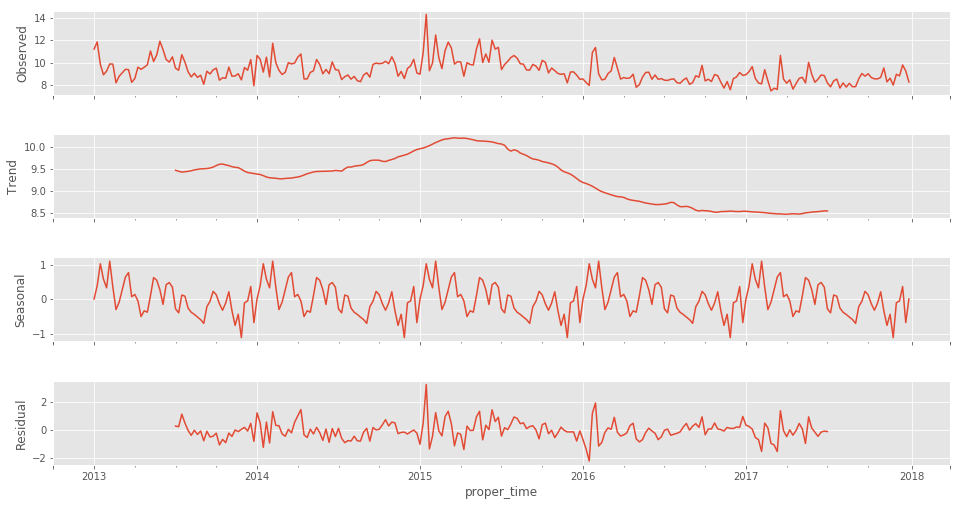

In [25]:
decomposition = seasonal_decompose(weekly_average_response_time, freq=52)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

<Figure size 432x288 with 0 Axes>

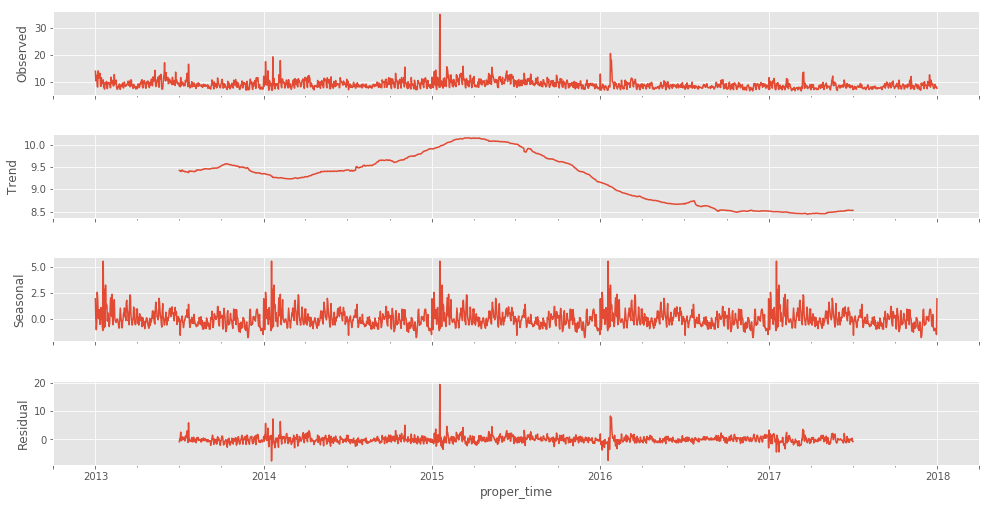

In [26]:
decomposition = seasonal_decompose(daily_average_response_time, freq=365)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

## Differencing

We take the first difference between weeks to improve stationarity. We tried taking a seasonal difference, but it didn't improve our DF score.

In [27]:
# Log mode:
# weekly_average_response_time = weekly_average_response_time.apply(lambda x: np.log(x))
# Tried this, didn't help.

In [28]:
week_first_diff = weekly_average_response_time - weekly_average_response_time.shift(1)

In [29]:
daily_first_diff = daily_average_response_time - daily_average_response_time.shift(1)

In [30]:
week_first_diff = week_first_diff.dropna()
dickey_fuller(week_first_diff)

Results of Dickey-Fuller Test:
Test Statistic                -9.955514e+00
p-value                        2.450230e-17
#Lags Used                     5.000000e+00
Number of Observations Used    2.540000e+02
Critical Value (1%)           -3.456360e+00
Critical Value (5%)           -2.872987e+00
Critical Value (10%)          -2.572870e+00
dtype: float64


In [31]:
daily_first_diff = daily_first_diff.dropna()
dickey_fuller(daily_first_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.357415e+01
p-value                        2.185929e-25
#Lags Used                     2.500000e+01
Number of Observations Used    1.799000e+03
Critical Value (1%)           -3.433990e+00
Critical Value (5%)           -2.863148e+00
Critical Value (10%)          -2.567626e+00
dtype: float64


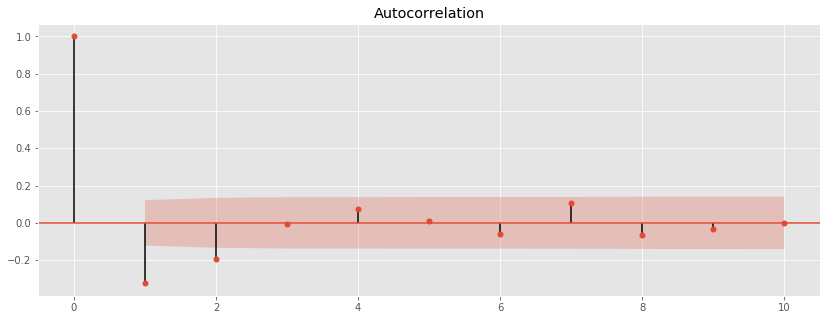

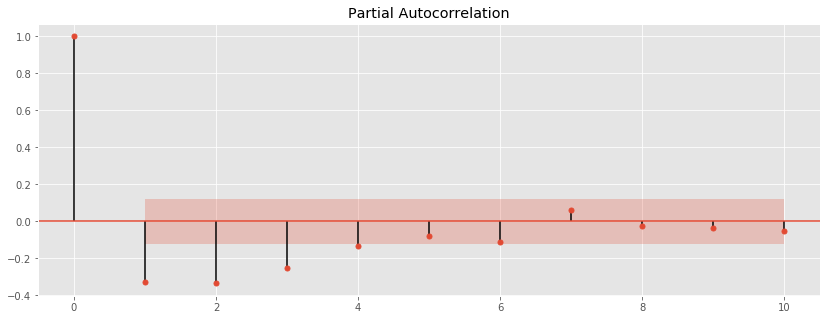

In [32]:
rcParams['figure.figsize'] = 14, 5
plot_acf(week_first_diff, lags = 10);

rcParams['figure.figsize'] = 14, 5
plot_pacf(week_first_diff, lags = 10);

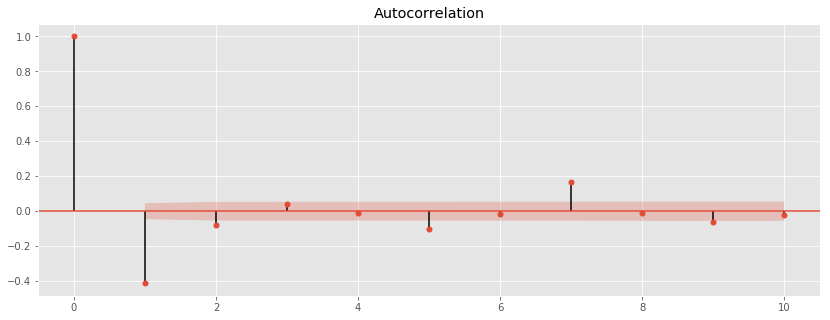

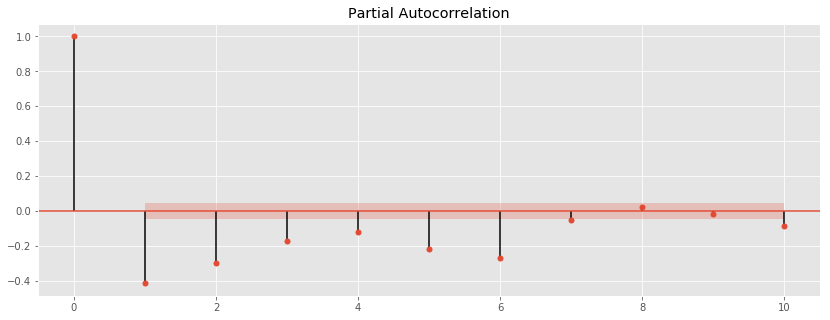

In [33]:
rcParams['figure.figsize'] = 14, 5
plot_acf(daily_first_diff, lags = 10);

rcParams['figure.figsize'] = 14, 5
plot_pacf(daily_first_diff, lags = 10);

### Seasonal Difference:

In [34]:
weekly_seasonal_difference = (weekly_average_response_time - weekly_average_response_time.shift(52)).dropna()

In [35]:
daily_seasonal_difference = (daily_average_response_time - daily_average_response_time.shift(52)).dropna()

In [36]:
dickey_fuller(weekly_seasonal_difference)

Results of Dickey-Fuller Test:
Test Statistic                  -2.069017
p-value                          0.257154
#Lags Used                       6.000000
Number of Observations Used    202.000000
Critical Value (1%)             -3.463144
Critical Value (5%)             -2.875957
Critical Value (10%)            -2.574455
dtype: float64


In [37]:
dickey_fuller(daily_seasonal_difference)

Results of Dickey-Fuller Test:
Test Statistic                -7.351159e+00
p-value                        1.005156e-10
#Lags Used                     2.200000e+01
Number of Observations Used    1.751000e+03
Critical Value (1%)           -3.434090e+00
Critical Value (5%)           -2.863192e+00
Critical Value (10%)          -2.567649e+00
dtype: float64


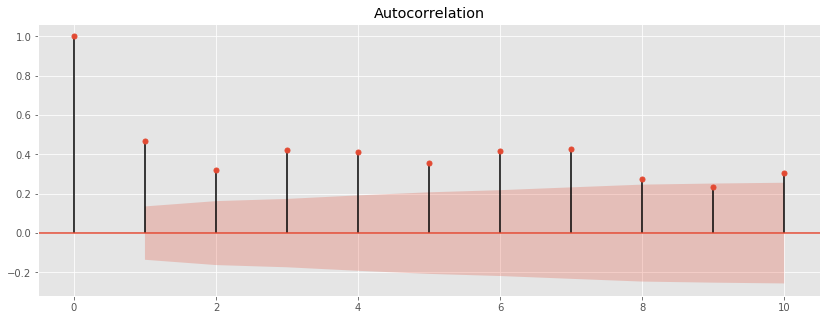

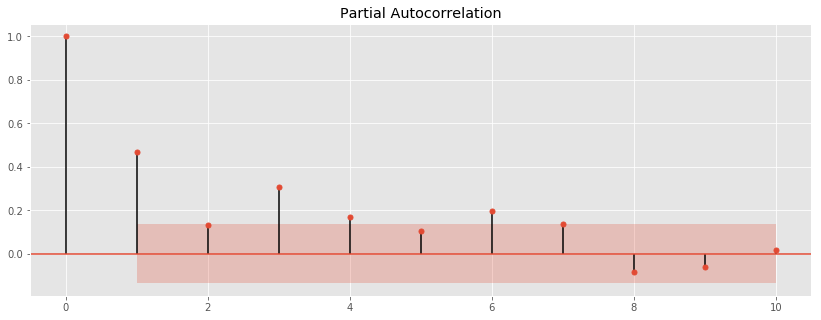

In [38]:
rcParams['figure.figsize'] = 14, 5
plot_acf(weekly_seasonal_difference, lags = 10);

rcParams['figure.figsize'] = 14, 5
plot_pacf(weekly_seasonal_difference, lags = 10);

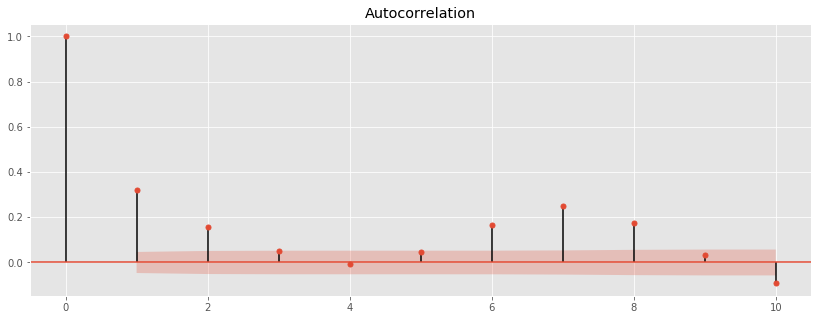

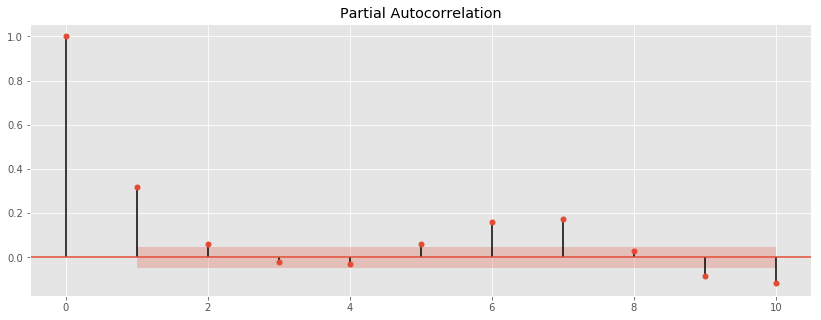

In [39]:
rcParams['figure.figsize'] = 14, 5
plot_acf(daily_seasonal_difference, lags = 10);

rcParams['figure.figsize'] = 14, 5
plot_pacf(daily_seasonal_difference, lags = 10);

### Seasonal FIRST Differences

In [40]:
weekly_seasonal_first_difference = (week_first_diff - week_first_diff.shift(52)).dropna()

In [41]:
daily_seasonal_first_difference = (daily_first_diff - daily_first_diff.shift(52)).dropna()

In [42]:
dickey_fuller(weekly_seasonal_first_difference)

Results of Dickey-Fuller Test:
Test Statistic                -1.025001e+01
p-value                        4.511493e-18
#Lags Used                     5.000000e+00
Number of Observations Used    2.020000e+02
Critical Value (1%)           -3.463144e+00
Critical Value (5%)           -2.875957e+00
Critical Value (10%)          -2.574455e+00
dtype: float64


In [43]:
dickey_fuller(daily_seasonal_first_difference)

Results of Dickey-Fuller Test:
Test Statistic                -1.377476e+01
p-value                        9.535968e-26
#Lags Used                     2.500000e+01
Number of Observations Used    1.747000e+03
Critical Value (1%)           -3.434099e+00
Critical Value (5%)           -2.863196e+00
Critical Value (10%)          -2.567652e+00
dtype: float64


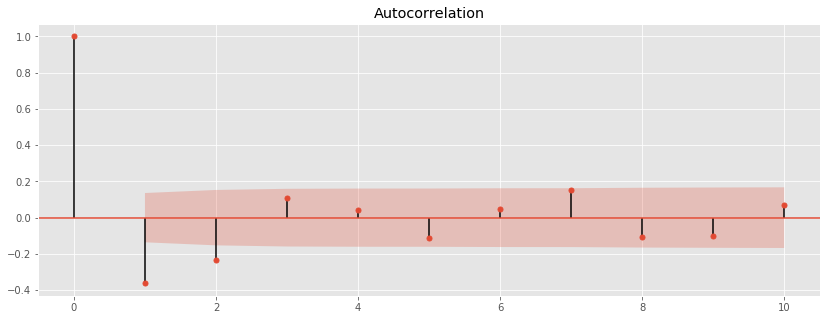

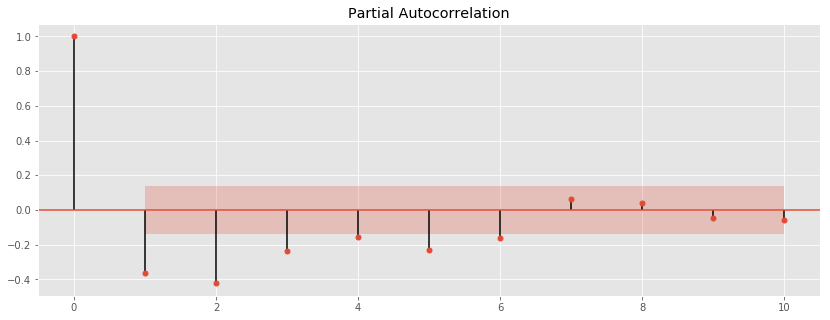

In [44]:
rcParams['figure.figsize'] = 14, 5
plot_acf(weekly_seasonal_first_difference, lags = 10);

rcParams['figure.figsize'] = 14, 5
plot_pacf(weekly_seasonal_first_difference, lags = 10);

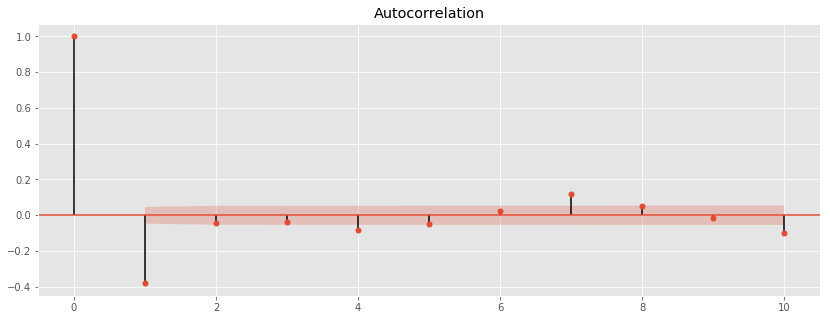

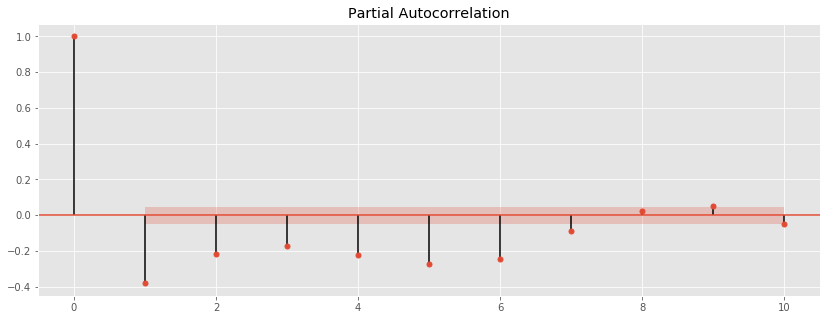

In [45]:
rcParams['figure.figsize'] = 14, 5
plot_acf(daily_seasonal_first_difference, lags = 10);

rcParams['figure.figsize'] = 14, 5
plot_pacf(daily_seasonal_first_difference, lags = 10);

# Forecasting

### SARIMA Step 1: Grid Search for Ideal Params

In [46]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [47]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(weekly_average_response_time,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}52 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 52)52 : AIC Calculated =1899.6568919874746
ARIMA (0, 0, 0) x (0, 0, 1, 52)52 : AIC Calculated =1355.2659275162491
ARIMA (0, 0, 0) x (0, 1, 0, 52)52 : AIC Calculated =725.4797962187847
ARIMA (0, 0, 0) x (0, 1, 1, 52)52 : AIC Calculated =510.18390309299554
ARIMA (0, 0, 0) x (1, 0, 0, 52)52 : AIC Calculated =718.0288127888143
ARIMA (0, 0, 0) x (1, 0, 1, 52)52 : AIC Calculated =630.7199203070456
ARIMA (0, 0, 0) x (1, 1, 0, 52)52 : AIC Calculated =531.5390429190228
ARIMA (0, 0, 0) x (1, 1, 1, 52)52 : AIC Calculated =525.7958872682482
ARIMA (0, 0, 1) x (0, 0, 0, 52)52 : AIC Calculated =1571.571426178552
ARIMA (0, 0, 1) x (0, 0, 1, 52)52 : AIC Calculated =1122.4585773156737
ARIMA (0, 0, 1) x (0, 1, 0, 52)52 : AIC Calculated =681.1327079044411
ARIMA (0, 0, 1) x (0, 1, 1, 52)52 : AIC Calculated =460.87049928800184
ARIMA (0, 0, 1) x (1, 0, 0, 52)52 : AIC Calculated =678.6224672935297
ARIMA (0, 0, 1) x (1, 0, 1, 52)52 : AIC Calculated =679.3730378856817
ARIMA (0, 0, 1)

In [49]:
# Find the parameters with minimal AIC value.

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 1, 1, 52)
aic           412.709
Name: 43, dtype: object

Now plug ideal params into SARIMAX model:

In [151]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(weekly_average_response_time,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9863      0.021     46.746      0.000       0.945       1.028
ma.L1         -0.8282      0.041    -20.102      0.000      -0.909      -0.747
ma.S.L52      -1.0000   1149.194     -0.001      0.999   -2253.379    2251.379
sigma2         0.5862    673.680      0.001      0.999   -1319.803    1320.975


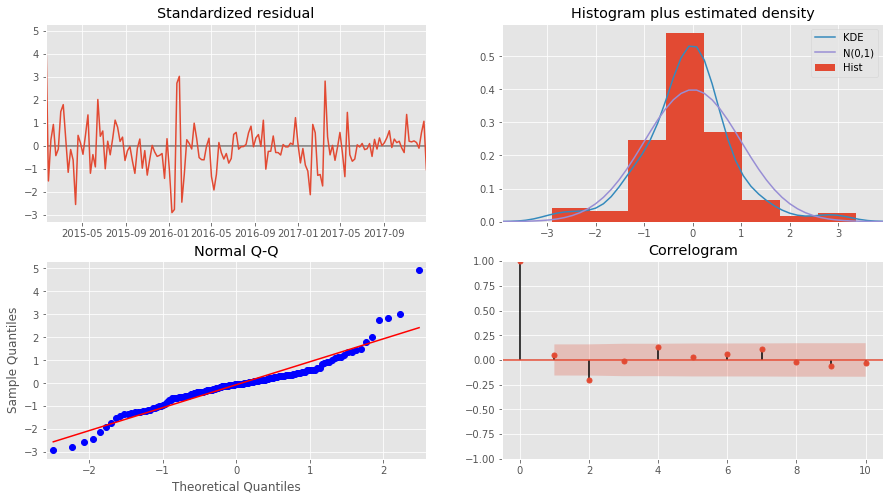

In [152]:
output.plot_diagnostics(figsize=(15, 8))
plt.show()

In [153]:
# Get dynamic predictions with confidence intervals as above.

pred_dynamic = output.get_prediction(start = weekly_average_response_time.index[-50],
                                     dynamic = True, 
                                     full_results = True)

pred_dynamic_conf = pred_dynamic.conf_int()

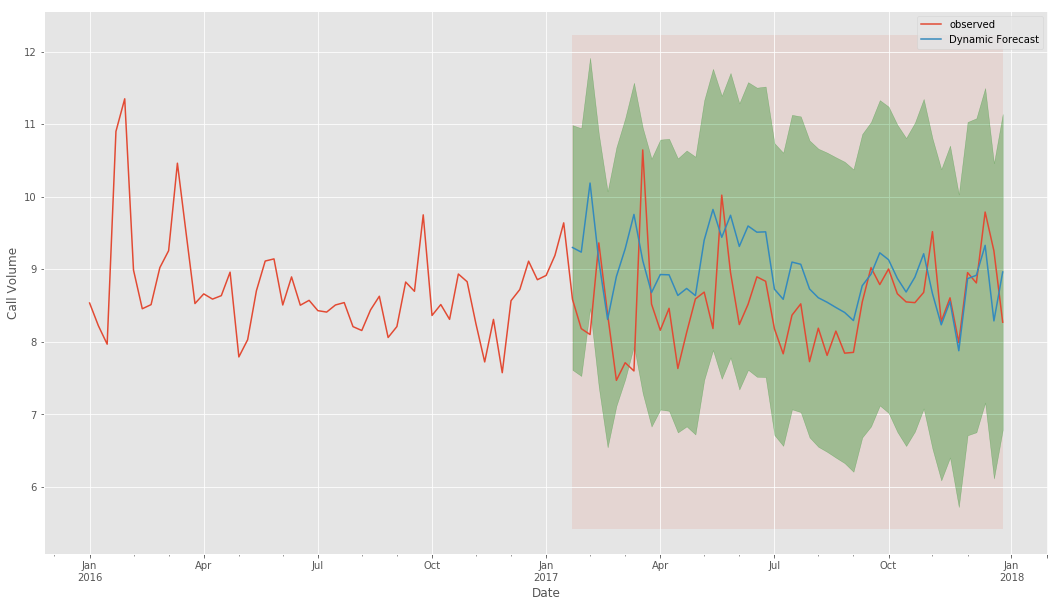

In [157]:
# Plot the dynamic forecast with confidence intervals.

ax = weekly_average_response_time['2016-01-01':].plot(label='observed', figsize=(18, 10))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), 
                 weekly_average_response_time[-50:-49].index[0], 
                 '2017-12-31', 
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Call Volume')

plt.legend()
plt.show()

## Facebook Prophet

In [162]:
df = pd.DataFrame(weekly_average_response_time) # Formatting a DF how Prophet likes it

In [163]:
df.columns = ['y']

In [164]:
df['ds'] = df.index

In [165]:
m = Prophet(weekly_seasonality=True)
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [166]:
future = m.make_future_dataframe(periods=52, freq='W')
forecast = m.predict(future)

In [167]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][:3]

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-06,9.625144,8.694553,10.622465
1,2013-01-13,9.930549,9.013118,10.887764
2,2013-01-20,10.159663,9.201704,11.135841


In [168]:
forecast.index = pd.date_range(start=df.index[0], periods=len(forecast), freq='W')

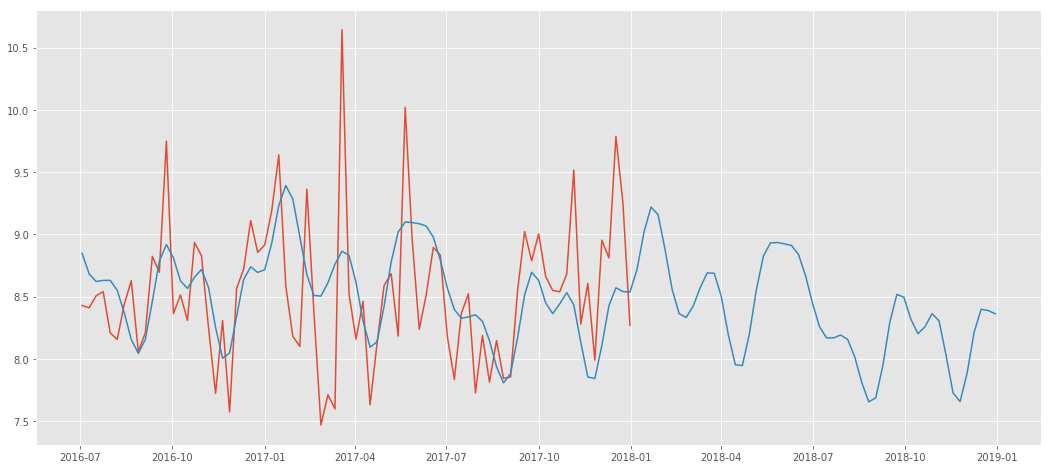

In [172]:
plt.figure(figsize=(18,8))
plt.plot(df['y']['2016-07-01':])
plt.plot(forecast['yhat']['2016-07-01':])
plt.show()

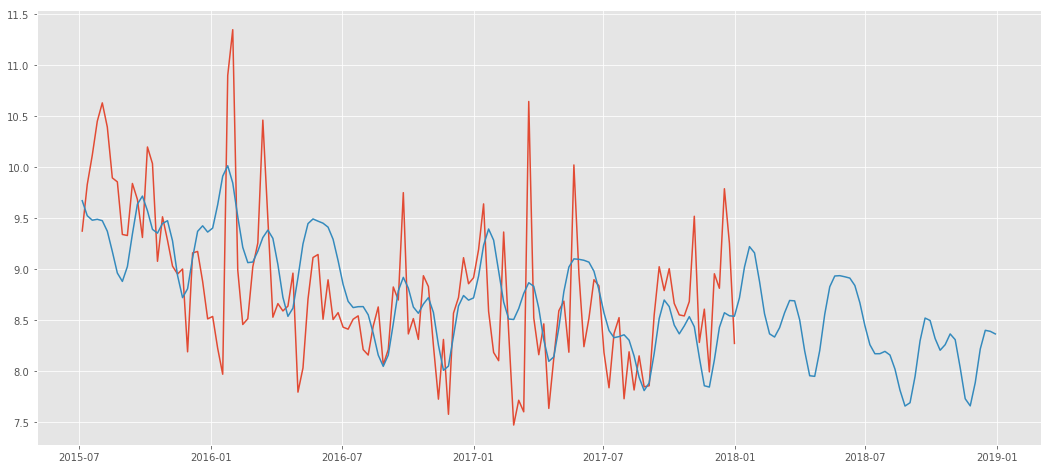

In [171]:
plt.figure(figsize=(18,8))
plt.plot(df['y']['2015-07-01':])
plt.plot(forecast['yhat']['2015-07-01':])
plt.show()

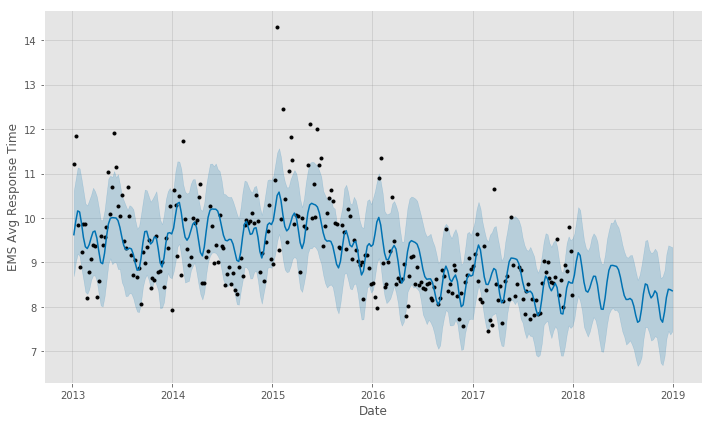

In [176]:
fig1 = m.plot(forecast, xlabel='Date', ylabel='EMS Avg Response Time')

## Let's see what some multivariate stuff looks like 

In [ ]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(weekly_average_response_time,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}52 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [ ]:
# Find the parameters with minimal AIC value.

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [180]:
weekly_average_response_time_df.head()

,avg_response_time_min,avg_temp,total_precip,total_snowfall,total_holidays
proper_time,,,,,
2013-01-06,11.203026,33.166667,0.0001,0.001,1.0
2013-01-13,11.848662,43.214286,0.5700,0.000,0.0
2013-01-20,9.846154,38.428571,0.9000,0.001,0.0
2013-01-27,8.906825,21.071429,0.0701,1.501,1.0
2013-02-03,9.237061,35.428571,1.2600,0.401,0.0


In [287]:
endogenous_train = weekly_average_response_time[:-52]
exogenous_train = weekly_average_response_time_df.drop(['avg_response_time_min'], axis=1)[:-52]
endogenous_test = weekly_average_response_time[-52:]
exogenous_test = weekly_average_response_time_df.drop(['avg_response_time_min'], axis=1)[-52:]

In [258]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(endogenous_train,
                                exog = exogenous_train,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp           0.0112         -0       -inf      0.000       0.011       0.011
total_precip       0.1621         -0       -inf      0.000       0.162       0.162
total_snowfall     0.0688   2.54e-38    2.7e+36      0.000       0.069       0.069
total_holidays     0.1355      3e-38   4.51e+36      0.000       0.135       0.135
ar.L1              0.8762   2.44e-35   3.59e+34      0.000       0.876       0.876
ma.L1             -0.4783   3.47e-35  -1.38e+34      0.000      -0.478      -0.478
ma.S.L52       -1.279e+15   2.77e-34  -4.61e+48      0.000   -1.28e+15   -1.28e+15
sigma2          3.231e-13   1.87e-10      0.002      0.999   -3.66e-10    3.67e-10


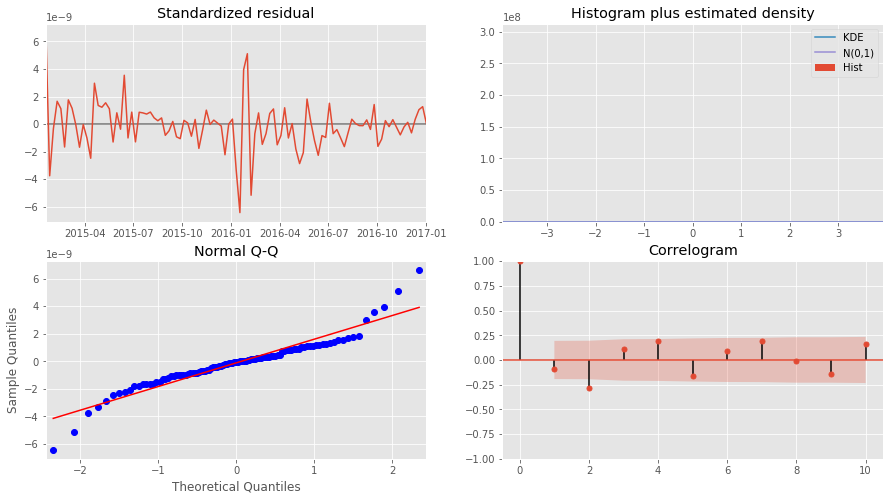

In [259]:
output.plot_diagnostics(figsize=(15, 8))
plt.show()

###### Static 

In [254]:
endogenous_test.index[0:2]

DatetimeIndex(['2017-01-08', '2017-01-15'], dtype='datetime64[ns]', name='proper_time', freq='W-SUN')

In [292]:
prediction_f = output.get_forecast(steps=52, exog = exogenous_test)
pred_conf_f = prediction_f.conf_int()

In [302]:
prediction = output.get_prediction(start = endogenous_test.index[0],
                                    end = endogenous_test.index[-1],
                                    exog = exogenous_test,
                                    dynamic = False)

pred_conf = prediction.conf_int()

In [303]:
pred_conf_f.head()

,lower INCIDENT_RESPONSE_SECONDS_QY,upper INCIDENT_RESPONSE_SECONDS_QY
2017-01-08,-1.424496e+09,1.424496e+09
2017-01-15,-1.533098e+09,1.533098e+09
2017-01-22,-1.611507e+09,1.611507e+09
2017-01-29,-1.669201e+09,1.669201e+09
2017-02-05,-1.712171e+09,1.712171e+09


In [296]:
pred_conf.head()

,lower INCIDENT_RESPONSE_SECONDS_QY,upper INCIDENT_RESPONSE_SECONDS_QY
proper_time,,
2014-03-09,-1.424496e+09,1.424496e+09
2014-03-16,-1.424496e+09,1.424496e+09
2014-03-23,-1.424496e+09,1.424496e+09
2014-03-30,-1.424496e+09,1.424496e+09
2014-04-06,-1.424496e+09,1.424496e+09


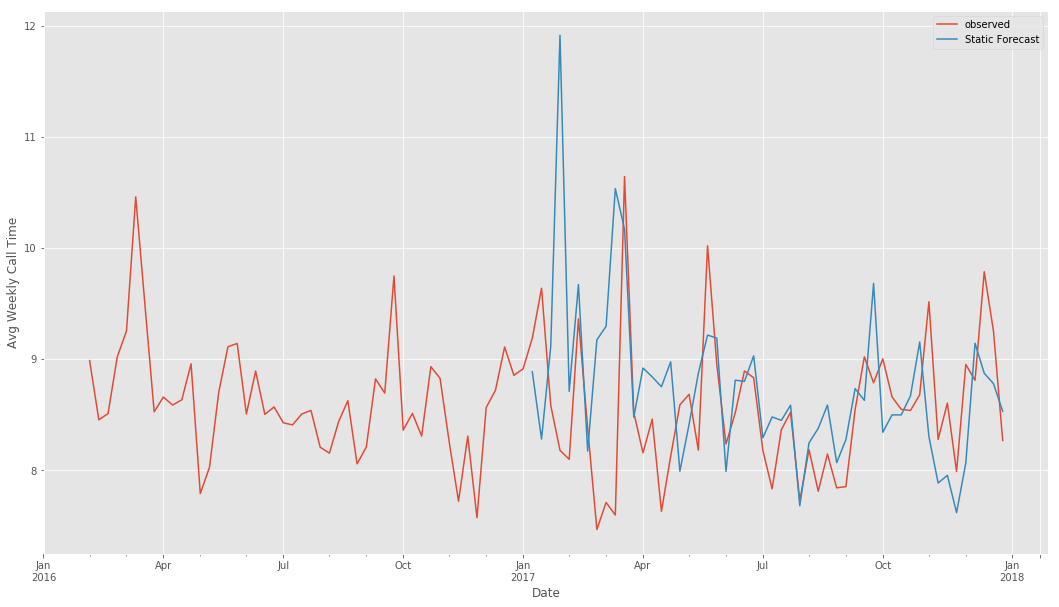

In [299]:
# Plot the static forecast with confidence intervals.

ax = weekly_average_response_time[-100:].plot(label='observed', figsize=(18, 10))
prediction.predicted_mean.plot(label='Static Forecast', ax=ax)

# ax.fill_between(pred_conf.index,
#                 pred_conf.iloc[:, 0],
#                 pred_conf.iloc[:, 1], color='g', alpha=.3)

# ax.fill_betweenx(ax.get_ylim(), 
#                  weekly_average_response_time[-50:-49].index[0], 
#                  '2017-12-31', 
#                  alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Weekly Call Time')

plt.legend()
plt.show()

In [301]:
mse = ((prediction.predicted_mean - endogenous_test)**2).mean()
rmse = np.sqrt(mse)
print('The MSE for this model is {}'.format(mse))
print('The RMSE for this model is {}'.format(rmse))

The MSE for this model is 0.8180191200198077
The RMSE for this model is 0.904444094468977


## What about some CV? 

In [319]:
weekly_average_response_time_df.head()

,avg_response_time_min,avg_temp,total_precip,total_snowfall,total_holidays
proper_time,,,,,
2013-01-06,11.203026,33.166667,0.0001,0.001,1.0
2013-01-13,11.848662,43.214286,0.5700,0.000,0.0
2013-01-20,9.846154,38.428571,0.9000,0.001,0.0
2013-01-27,8.906825,21.071429,0.0701,1.501,1.0
2013-02-03,9.237061,35.428571,1.2600,0.401,0.0


In [333]:
values = weekly_average_response_time_df.avg_response_time_min

tscv = TimeSeriesSplit(n_splits=5) 

# iterating over folds, train model on each, forecast and calculate error
for train, test in tscv.split(values):
#     print(values[train])
    model = ARIMA_MODEL = sm.tsa.statespace.SARIMAX(values[train],
#                                 exog = exogenous_train,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    output = ARIMA_MODEL.fit()

    print(output.summary().tables[1])


ValueError: maxlag should be < nobs

## Let's look at some stuff with call volume

In [343]:
endogenous_train = weekly_call_volume[:-52]
exogenous_train = weekly_call_volume_df.drop(['sum of weekly calls'], axis=1)[:-52]
endogenous_test = weekly_call_volume[-52:]
exogenous_test = weekly_call_volume_df.drop(['sum of weekly calls'], axis=1)[-52:]

In [344]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(endogenous_train,
                                exog = exogenous_train,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp          86.6069         -0       -inf      0.000      86.607      86.607
total_precip     -29.8947         -0        inf      0.000     -29.895     -29.895
total_snowfall    37.3603   1.92e-37   1.95e+38      0.000      37.360      37.360
total_holidays   230.0114   2.91e-37   7.91e+38      0.000     230.011     230.011
ar.L1              0.9385   7.64e-35   1.23e+34      0.000       0.938       0.938
ma.L1             -0.4361   2.49e-34  -1.75e+33      0.000      -0.436      -0.436
ma.S.L52       -7.051e+14   8.34e-33  -8.45e+46      0.000   -7.05e+14   -7.05e+14
sigma2          3.669e-09   7.61e-10      4.820      0.000    2.18e-09    5.16e-09


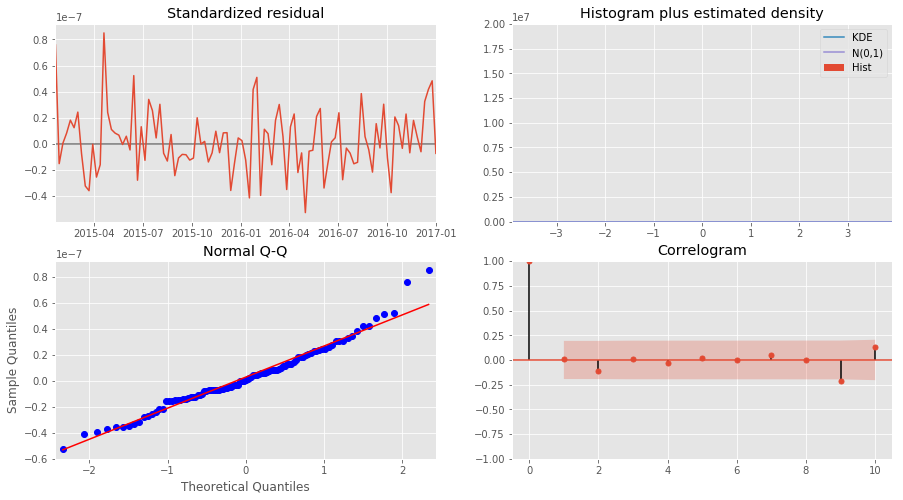

In [345]:
output.plot_diagnostics(figsize=(15, 8))
plt.show()

In [346]:
prediction = output.get_prediction(start = endogenous_test.index[0],
                                    end = endogenous_test.index[-1],
                                    exog = exogenous_test,
                                    dynamic = False)

pred_conf = prediction.conf_int()

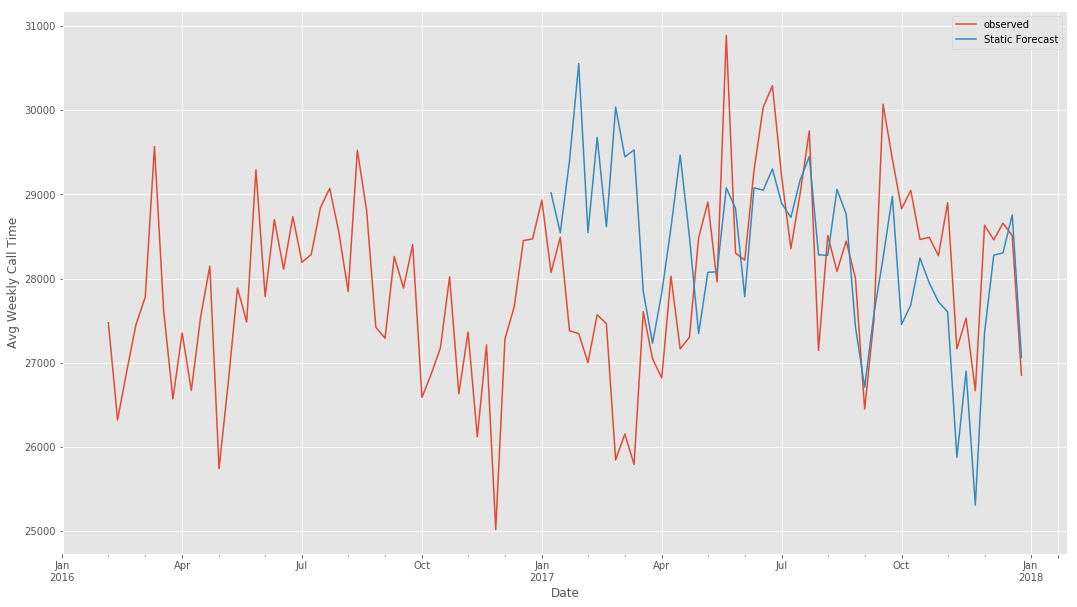

In [348]:
# Plot the static forecast with confidence intervals.

ax = weekly_call_volume[-100:].plot(label='observed', figsize=(18, 10))
prediction.predicted_mean.plot(label='Static Forecast', ax=ax)

# ax.fill_between(pred_conf.index,
#                 pred_conf.iloc[:, 0],
#                 pred_conf.iloc[:, 1], color='g', alpha=.3)

# ax.fill_betweenx(ax.get_ylim(), 
#                  weekly_average_response_time[-50:-49].index[0], 
#                  '2017-12-31', 
#                  alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Weekly Call Time')

plt.legend()
plt.show()

In [349]:
mse = ((prediction.predicted_mean - endogenous_test)**2).mean()
rmse = np.sqrt(mse)
print('The MSE for this model is {}'.format(mse))
print('The RMSE for this model is {}'.format(rmse))

The MSE for this model is 1928712.2918200283
The RMSE for this model is 1388.78086529878


In [350]:
rmse/7

198.3972664712543

## Some EDA

In [351]:
weekly_call_volume_df.describe()

,sum of weekly calls,avg_temp,total_precip,total_snowfall,total_holidays
count,261.000000,261.000000,261.000000,261.000000,261.000000
mean,26908.908046,56.071793,0.871084,0.745115,0.206897
std,1633.880527,16.843613,0.928910,2.718872,0.433357
min,22877.000000,20.714286,0.000000,0.000000,0.000000
25%,25892.000000,41.357143,0.200200,0.000000,0.000000
50%,26965.000000,56.928571,0.560000,0.000000,0.000000
75%,28148.000000,72.285714,1.330000,0.001000,0.000000
max,30891.000000,86.857143,5.640000,26.802000,2.000000


In [353]:
weekly_average_response_time_df.describe()

,avg_response_time_min,avg_temp,total_precip,total_snowfall,total_holidays
count,261.000000,261.000000,261.000000,261.000000,261.000000
mean,9.257259,56.071793,0.871084,0.745115,0.206897
std,1.006619,16.843613,0.928910,2.718872,0.433357
min,7.469212,20.714286,0.000000,0.000000,0.000000
25%,8.539728,41.357143,0.200200,0.000000,0.000000
50%,9.028101,56.928571,0.560000,0.000000,0.000000
75%,9.863349,72.285714,1.330000,0.001000,0.000000
max,14.297593,86.857143,5.640000,26.802000,2.000000


In [365]:
weekly_average_response_time_df.nlargest(10, 'avg_response_time_min')

,avg_response_time_min,avg_temp,total_precip,total_snowfall,total_holidays
proper_time,,,,,
2015-01-18,14.297593,30.000000,2.4600,0.001,0.0
2015-02-08,12.459994,27.142857,1.0400,3.301,0.0
2015-05-17,12.116504,68.500000,0.3201,0.000,0.0
2015-06-14,11.998787,76.714286,0.4300,0.000,0.0
2013-06-02,11.907463,73.928571,1.3700,0.000,1.0
2013-01-13,11.848662,43.214286,0.5700,0.000,0.0
2015-03-08,11.823296,31.785714,1.6800,9.300,0.0
2014-02-09,11.722950,28.642857,2.7000,13.200,0.0
2015-06-28,11.356865,74.000000,1.4300,0.000,0.0


In [368]:
weekly_average_response_time_df.nsmallest(10, 'avg_response_time_min')

,avg_response_time_min,avg_temp,total_precip,total_snowfall,total_holidays
proper_time,,,,,
2017-02-26,7.469212,49.857143,0.5400,0.0,1.0
2016-11-27,7.574476,42.785714,0.0500,0.0,1.0
2017-03-12,7.599000,39.071429,0.4300,2.1,0.0
2017-04-16,7.632342,63.642857,0.0201,0.0,0.0
2017-03-05,7.712322,41.357143,0.1200,0.0,0.0
2016-11-13,7.723111,49.857143,0.0600,0.0,1.0
2017-07-30,7.727002,71.428571,0.7401,0.0,0.0
2016-05-01,7.792051,53.642857,0.4500,0.0,0.0
2017-08-13,7.813079,73.142857,0.8701,0.0,0.0


In [367]:
weekly_call_volume_df.nlargest(10, 'sum of weekly calls')

,sum of weekly calls,avg_temp,total_precip,total_snowfall,total_holidays
proper_time,,,,,
2017-05-21,30891,69.642857,0.0100,0.0,0.0
2015-06-14,30694,76.714286,0.4300,0.0,0.0
2017-06-25,30292,77.285714,2.7100,0.0,0.0
2015-08-02,30263,82.071429,2.3100,0.0,0.0
2017-09-17,30073,72.500000,0.0800,0.0,0.0
2017-06-18,30036,75.642857,1.6802,0.0,0.0
2015-07-26,30004,80.357143,0.0002,0.0,0.0
2015-08-09,29767,77.714286,0.4300,0.0,0.0
2015-05-17,29766,68.500000,0.3201,0.0,0.0


In [369]:
weekly_call_volume_df.nsmallest(10, 'sum of weekly calls')

,sum of weekly calls,avg_temp,total_precip,total_snowfall,total_holidays
proper_time,,,,,
2013-12-01,22877,36.928571,2.4900,0.001,1.0
2013-02-24,22926,34.071429,0.4200,0.000,1.0
2013-03-31,23158,45.357143,0.2501,0.001,0.0
2013-01-27,23313,21.071429,0.0701,1.501,1.0
2013-01-06,23449,33.166667,0.0001,0.001,1.0
2013-12-29,23719,38.642857,1.7102,0.002,1.0
2014-03-02,23743,27.785714,0.0301,0.201,0.0
2014-11-30,23841,45.428571,1.9600,0.201,1.0
2013-03-24,23847,36.642857,1.0102,3.002,0.0
